<a href="https://colab.research.google.com/github/Nganle21/Big-Data-Dreamteam/blob/main/Ngan/Trained_notebooks/Lyrics_Gen_pop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sources of reference:

- https://www.tensorflow.org/text/tutorials/text_generation
- https://towardsdatascience.com/song-lyrics-generation-with-artificial-intelligence-rnn-cdba26738530

# Load the created txt file

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_pop.txt', 'rb').read().decode(encoding='utf-8')

# Preprocess text before putting them into the model

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

197 unique characters


For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the tf.data.Dataset.from_tensor_slices function to convert the text vector into a stream of character indices.

In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we shuffle the data and pack it into batches.

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

# Building RNN model
Here, we start building the RNN model:

- Embedding layer: The input layer. A trainable lookup table that will map each character-ID to a vector with embedding_dim dimensions;
- GRU (Gated Recurrent Units): A type of RNN with size units=rnn_units
- Dense: The output layer, with vocab_size outputs. It outputs one logit for each character in the vocabulary

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

197

Now, we build the model

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

First check the shape of the output:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 197) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (10, None, 256)           50432     
                                                                 
 gru (GRU)                   (10, None, 1024)          3938304   
                                                                 
 dense (Dense)               (10, None, 197)           201925    
                                                                 
Total params: 4,190,661
Trainable params: 4,190,661
Non-trainable params: 0
_________________________________________________________________


Try it for the first example in the batch:

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [ ]:
sampled_indices

array([  3,  41,  28,  94,  26, 100, 179,  48,  72, 139,  44,  29, 154,
       138, 112,   3,  88, 111,  33, 177, 190,  19,  40,  88,  96, 161,
        42, 188, 159, 191, 104, 156,  80, 159,  22,  20, 134,  72,  69,
        98,  64,   2,  67,  43,  90, 192,  30,  31,  41,  29, 150, 128,
       189,  40,  74,  77,  14, 141, 111, 182,  99, 162, 100, 118, 171,
        92, 143, 191, 195,   1,  48,  81,  88, 111, 175,  41,  99, 114,
       125, 172, 179,  85,  91,   2, 173, 118,  37, 127,  69, 158, 130,
        81,  51, 157,   8, 162, 154, 157, 127,  23])

Prepare loss function before training the model

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

Define Early Stopping

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

Configure checkpoints during the training

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_pop'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

Compile the model

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS=50

Start training the model

In [ ]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
6003/6003 [==============================] - 162s 26ms/step - loss: 1.3629
Epoch 2/50
6003/6003 [==============================] - 160s 26ms/step - loss: 1.1347
Epoch 3/50
6003/6003 [==============================] - 158s 26ms/step - loss: 1.1171
Epoch 4/50
6003/6003 [==============================] - 158s 26ms/step - loss: 1.1490


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_4'

Build the model with the saved weights of the latest checkpoint

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            50432     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 197)            201925    
                                                                 
Total params: 4,190,661
Trainable params: 4,190,661
Non-trainable params: 0
_________________________________________________________________


Function to generate texts

In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


This is the result, our generated lyrics!

In [ ]:
print(generate_text(model, start_string=u"i just want",t=0.3))

i just want it
i don't know where i wanted to be the one

you know i want you to know what it was to something to live away
and i can't get close to me

i wanna tell you to get through

i want you to have it
i wanna get your body

i don't know where to go

i know you're gonna leave me all over you

the way you make me feel a little better
then i just can't help it
i think i'm in love with your body
i know that you're feeling like i can feel your hair
and i know that i can't help it is we


Save the model for the further use

In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/pop_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/pop_model.h5")

Print out loss function

[Text(0.5, 0, 'Epochs')]

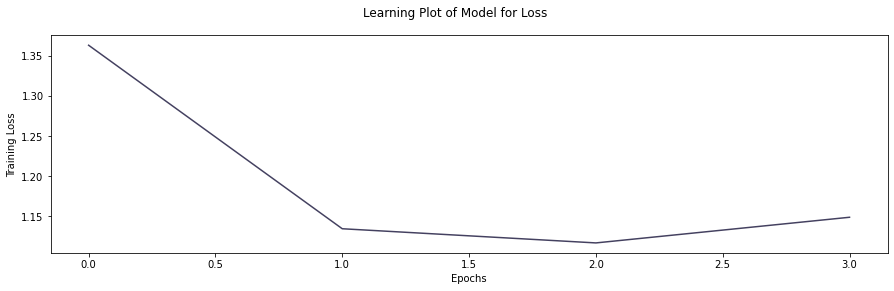

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")